#### Idea to try

- [x] scaling vs no-scaling -> not help
- [ ] ~~add more stats~~
- [ ] bootstrap data to balance
- [x] swap classes 0(-) 1(+) to 0(+) 1(-)
- [ ] get statistic for each time-range

## TODO

- [ ] Classification for each participant
- [ ] find the memorable part

In [16]:
import pandas as pd
from sklearn.model_selection import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.ensemble import *
from sklearn.compose import *
from sklearn.svm import SVC
from sklearn import datasets, svm, metrics

from pipelinehelper import PipelineHelper

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

#### ERSP Data Description

The file `ERSP_data.csv` contains EEG power (event-related spectral potentials) at different sensors distributed across
the scalp of the participants over time and different frequency bands. Each row represents one trial.

The format of the column names is Sensor_frequency_time, where:

* there are 28 sensors
* frequency is the frequency (in Hz) between 2--29.
* time represents the time within the trial. time=0 corresponds to 1 second before the start of the video, and time=4
corresponds to the end of the video (3 seconds).

**The last 3 columns are:**
 - `subject`: participant ID
 - `filename`: name of the video that corresponds to the trial
 - `LABEL`: 
   - **1** if the video was **remembered** by the participant;
   - **2** if the video was **not remembered.** 
   - Missing values represent the test set.

## Random Forest tryout

In [4]:
# Read processed data back into the DF
df = pd.read_csv('../data/EEG_task3/ERSP2_preRdForest_subject19.csv', index_col=0)
df.head()

time   c2_mean     c2_std    c2_min    c2_25%    c2_50%    c2_75%  \
0     0  0.239730   1.739533 -2.575699 -1.046209 -0.143541  1.140169   
1     1  2.333662   6.612182 -4.100673 -1.520518 -0.450355  4.111748   
2     2  3.139406  11.049177 -6.375597 -1.339767 -0.284037  1.620236   
3     3  1.882652   4.345697 -3.560903 -0.711959  0.615189  2.775698   
4     4  3.264781   6.562513 -3.343909 -0.417991  1.117547  3.652127   

      c2_max       c2_k   c3_mean  ...  c29_mean    c29_std   c29_min  \
0   3.463418  -0.737194  0.194243  ...  0.985883   1.454610 -1.912107   
1  24.459396   4.162462  0.736334  ...  5.749916  17.068890 -2.486181   
2  52.963678  16.075810  2.588768  ...  3.119938   8.164142 -2.636478   
3  16.737517   3.935646  0.809367  ... -0.017776   2.053108 -3.454196   
4  19.591319   2.079825  1.243768  ...  1.624854   5.360781 -1.798278   

    c29_25%   c29_50%   c29_75%    c29_max      c29_k  file_id  label  
0 -0.213773  0.936923  2.308789   3.711272  -1.043263   2448.0    2.0  
1 -0.810120  0.688327  2.954922  75.553845  12.076019   2448.0    2.0  
2 -0.890893  0.319719  2.047539  31.429874   6.512923   2448.0    2.0  
3 -1.378522 -0.675203  1.040171   6.590498   2.752594   2448.0    2.0  
4 -0.601014 -0.096055  1.331344  24.933496  14.090932   2448.0    2.0  

[5 rows x 227 columns]

In [9]:
# map the label 0 cannot remember, 1 remember
label_map = {2.0: 0, 1.0: 1}
df['new_label'] = df['label'].map(label_map)
df.pop('label')

KeyError: 'label'

In [10]:
df['new_label'].value_counts()

0    10740
1      420
Name: new_label, dtype: int64

In [11]:
df.shape

(11160, 227)

Model training with simple random forest algorithm.

In [12]:
# create feature DF and target DF
feature_df = df.drop(['new_label'],axis=1)
# label encoder
lab = LabelEncoder()
target_df = lab.fit_transform(df['new_label'])
# spilt train & test set 75%/25%
x_train, x_test, y_train, y_test = train_test_split(feature_df, target_df, 
                                                    test_size=0.25, random_state=0,
                                                    # must statify, imbalanced class
                                                    stratify=target_df)

In [13]:
# Scale data, maybe don't use it
col = ColumnTransformer(
    [('num', RobustScaler(), feature_df.columns[1:-1]),], 
    remainder='passthrough')
# RandomForest, parallel, fix random_state
clf = RandomForestClassifier(n_jobs=-1, random_state=0)
# for repreat unbalanced data
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=7, random_state=0)

### ROC AUC

In [9]:
# ROC AUC
pipe = make_pipeline(clf) # can add ColumnTransformer
%time scores = cross_val_score(pipe, feature_df, target_df, cv=rskf, scoring='roc_auc')
print("Avg score: {:.5} with std {:.5}".format(scores.mean(), scores.std()))

Avg score: 0.88024 with std 0.02164


In [10]:
# ROC AUC with ColumnTransformer
pipe = make_pipeline(col, clf) # can add ColumnTransformer
%time scores = cross_val_score(pipe, feature_df, target_df, cv=rskf, scoring='roc_auc')
print("Avg score: {:.5} with std {:.5}".format(scores.mean(), scores.std()))

CPU times: user 12.7 s, sys: 2.67 s, total: 15.4 s
Wall time: 42.9 s
Avg score: 0.88232 with std 0.023145


### F1-score

In [11]:
# Using F1 score
clf = RandomForestClassifier(n_jobs=-1, random_state=0)
pipe = make_pipeline(clf) # can add ColumnTransformer
%time scores = cross_val_score(pipe, feature_df, target_df, cv=rskf, scoring='f1')
print("Avg score: {:.5} with std {:.5}".format(scores.mean(), scores.std()))

CPU times: user 8.13 s, sys: 2.49 s, total: 10.6 s
Wall time: 38 s
Avg score: 0.058702 with std 0.036706


In [12]:
# Using F1 score # ColumnTransformer
clf = RandomForestClassifier(n_jobs=-1, random_state=0)
pipe = make_pipeline(col, clf) # can add ColumnTransformer
%time scores = cross_val_score(pipe, feature_df, target_df, cv=rskf, scoring='f1')
print("Avg score: {:.5} with std {:.5}".format(scores.mean(), scores.std()))

CPU times: user 11.9 s, sys: 2.56 s, total: 14.5 s
Wall time: 42.1 s
Avg score: 0.057733 with std 0.027004


### Average Precision

In [14]:
# Using avg pre score
clf = RandomForestClassifier(n_jobs=-1, random_state=0)
pipe = make_pipeline(clf) # can add ColumnTransformer
%time scores = cross_val_score(pipe, feature_df, target_df, cv=rskf, scoring='average_precision')
print("Avg score: {:.5} with std {:.5}".format(scores.mean(), scores.std()))

CPU times: user 8.21 s, sys: 2.32 s, total: 10.5 s
Wall time: 37.7 s
Avg score: 0.44021 with std 0.038948


In [15]:
# Using F1 score # ColumnTransformer
clf = RandomForestClassifier(n_jobs=-1, random_state=0)
pipe = make_pipeline(col, clf) # can add ColumnTransformer
%time scores = cross_val_score(pipe, feature_df, target_df, cv=rskf, scoring='average_precision')
print("Avg score: {:.5} with std {:.5}".format(scores.mean(), scores.std()))

CPU times: user 12.1 s, sys: 2.56 s, total: 14.7 s
Wall time: 41.9 s
Avg score: 0.44889 with std 0.042153


#### Simple Matrix Evaluation

In [13]:
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, y_pred)}\n"
)

Classification report for classifier RandomForestClassifier(n_jobs=-1, random_state=0):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2685
           1       1.00      0.01      0.02       105

    accuracy                           0.96      2790
   macro avg       0.98      0.50      0.50      2790
weighted avg       0.96      0.96      0.94      2790




We will try other classifier, perhaps they will work for the class 1 recall

In [8]:
# spilt train & test set 60%40%
x_train, x_test, y_train, y_test = train_test_split(feature_df, target_df, 
                                                    test_size=0.4, random_state=0,
                                                    stratify=target_df)
# RSKF for 10 splits 10 repeat fixed random state
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

NameError: name 'feature_df' is not defined

## GridSearchCV

In [59]:
# construct a pipeline
pipe = Pipeline([
    ('ct',ColumnTransformer(
        [('num', RobustScaler(), feature_df.columns[1:-1]),], 
        remainder='passthrough'
    )),
    # use PipelineHelper to cycle model selection
    ('classifier', PipelineHelper([
        ('et', ExtraTreesClassifier()),
        ('rf', RandomForestClassifier()),
        ('bc', BaggingClassifier()),
        ('xgb', xgb.XGBClassifier()),
    ]))])

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)
pipe

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  Index(['c2_mean', 'c2_std', 'c2_min', 'c2_25%', 'c2_50%', 'c2_75%', 'c2_max',
       'c2_k', 'c3_mean', 'c3_std',
       ...
       'c28_max', 'c28_k', 'c29_mean', 'c29_std', 'c29_min', 'c29_25%',
       'c29_50%', 'c29_75%', 'c29_max', 'c29_k'],
      dtype='object', length=224))])),
                ('classifier',
                 Pipelin...
                                                                       grow_policy=None,
                                                                       importance_type=None,
                                                                       interaction_constraints=None,
                                                                       learning_rate=None,
                                                                       max_bin=None,
                                                                       max_cat_threshold=None,
                                                                       max_cat_to_onehot=None,
                                                                       max_delta_step=None,
                                                                       max_depth=None,
                                                                       max_leaves=None,
                                                                       min_child_weight=None,
                                                                       missing=nan,
                                                                       monotone_constraints=None,
                                                                       n_estimators=100,
                                                                       n_jobs=None,
                                                                       num_parallel_tree=None,
                                                                       predictor=None,
                                                                       random_state=None, ...)}))])

In [60]:
# not actual parameter tuning, but set all classifier to use all CPUs and random state 0
params = {
    'classifier__selected_model': pipe.named_steps['classifier'].generate({
        'et__n_jobs': [-1],
        'et__random_state': [0],
        'rf__n_jobs': [-1],
        'rf__random_state': [0],
        'bc__n_jobs': [-1],
        'bc__random_state': [0],
        'xgb__n_jobs': [-1],
        'xgb__random_state': [0],
    })
}

### PR AUC

In [24]:
# grid search using `average precision` scoring
grid = GridSearchCV(pipe, params, cv=rskf, scoring='average_precision', verbose=0)

%time grid.fit(feature_df, target_df)

In [ ]:
# rank the algorithm, using SKlearn code
results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

In [29]:
#save result
results_df.to_csv('../data/EEG_task3/ERSP_data2_preavg_results.csv')

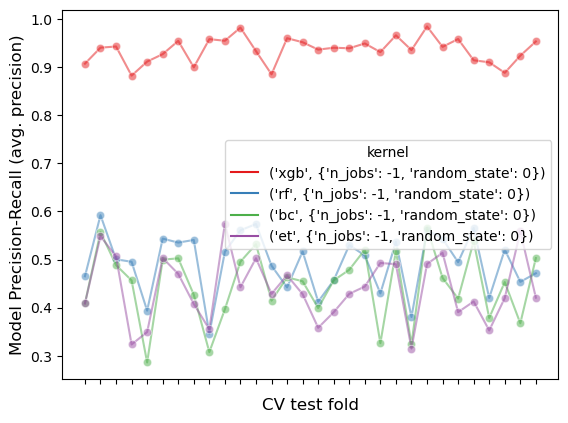

Correlation of models:
 kernel                                      ('xgb', {'n_jobs': -1, 'random_state': 0})  \
kernel                                                                                   
('xgb', {'n_jobs': -1, 'random_state': 0})                                    1.000000   
('rf', {'n_jobs': -1, 'random_state': 0})                                     0.366135   
('bc', {'n_jobs': -1, 'random_state': 0})                                     0.320458   
('et', {'n_jobs': -1, 'random_state': 0})                                     0.340498   

kernel                                      ('rf', {'n_jobs': -1, 'random_state': 0})  \
kernel                                                                                  
('xgb', {'n_jobs': -1, 'random_state': 0})                                   0.366135   
('rf', {'n_jobs': -1, 'random_state': 0})                                    1.000000   
('bc', {'n_jobs': -1, 'random_state': 0})                                    0.

In [30]:
# create df of model scores ordered by performance
# using sklearn code, not orginal
model_scores = results_df.filter(regex=r"split\d*_test_score")

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model Precision-Recall (avg. precision)", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

# print correlation of AUC scores across folds
print(f"Correlation of models:\n {model_scores.transpose().corr()}")

### ROC AUC

In [ ]:
grid = GridSearchCV(pipe, params, cv=rskf, scoring='roc_auc', verbose=3)
%time grid.fit(feature_df, target_df)

In [64]:
results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

params  \
kernel                                                                                          
('xgb', {'n_jobs': -1, 'random_state': 0})  {'classifier__selected_model': ('xgb', {'n_job...   
('rf', {'n_jobs': -1, 'random_state': 0})   {'classifier__selected_model': ('rf', {'n_jobs...   
('et', {'n_jobs': -1, 'random_state': 0})   {'classifier__selected_model': ('et', {'n_jobs...   
('bc', {'n_jobs': -1, 'random_state': 0})   {'classifier__selected_model': ('bc', {'n_jobs...   

                                            rank_test_score  mean_test_score  \
kernel                                                                         
('xgb', {'n_jobs': -1, 'random_state': 0})                1         0.991072   
('rf', {'n_jobs': -1, 'random_state': 0})                 2         0.889266   
('et', {'n_jobs': -1, 'random_state': 0})                 3         0.879132   
('bc', {'n_jobs': -1, 'random_state': 0})                 4         0.825151   

                                            std_test_score  
kernel                                                      
('xgb', {'n_jobs': -1, 'random_state': 0})        0.007788  
('rf', {'n_jobs': -1, 'random_state': 0})         0.030000  
('et', {'n_jobs': -1, 'random_state': 0})         0.032311  
('bc', {'n_jobs': -1, 'random_state': 0})         0.038570

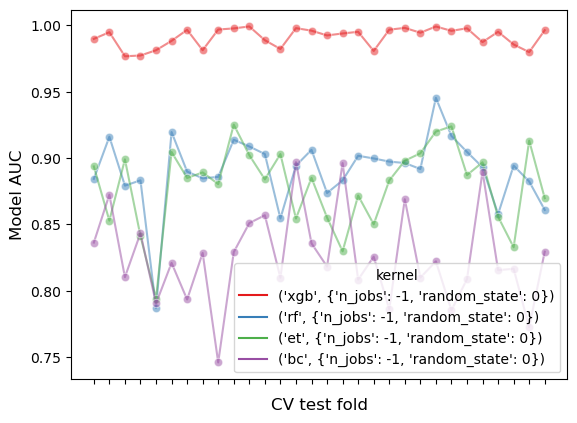

Correlation of models:
 kernel                                      ('xgb', {'n_jobs': -1, 'random_state': 0})  \
kernel                                                                                   
('xgb', {'n_jobs': -1, 'random_state': 0})                                    1.000000   
('rf', {'n_jobs': -1, 'random_state': 0})                                     0.322223   
('et', {'n_jobs': -1, 'random_state': 0})                                     0.312963   
('bc', {'n_jobs': -1, 'random_state': 0})                                     0.293616   

kernel                                      ('rf', {'n_jobs': -1, 'random_state': 0})  \
kernel                                                                                  
('xgb', {'n_jobs': -1, 'random_state': 0})                                   0.322223   
('rf', {'n_jobs': -1, 'random_state': 0})                                    1.000000   
('et', {'n_jobs': -1, 'random_state': 0})                                    0.

In [65]:
# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_score")

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

# print correlation of AUC scores across folds
print(f"Correlation of models:\n {model_scores.transpose().corr()}")

In [66]:
results_df.to_csv('../data/EEG_task3/ERSP_data2_rocauc_results.csv')

### F1

In [67]:
grid = GridSearchCV(pipe, params, cv=rskf, scoring='f1')
%time grid.fit(feature_df, target_df)

results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

CPU times: user 7h 44min 55s, sys: 17min 57s, total: 8h 2min 53s
Wall time: 19min 29s


params  \
kernel                                                                                          
('xgb', {'n_jobs': -1, 'random_state': 0})  {'classifier__selected_model': ('xgb', {'n_job...   
('bc', {'n_jobs': -1, 'random_state': 0})   {'classifier__selected_model': ('bc', {'n_jobs...   
('rf', {'n_jobs': -1, 'random_state': 0})   {'classifier__selected_model': ('rf', {'n_jobs...   
('et', {'n_jobs': -1, 'random_state': 0})   {'classifier__selected_model': ('et', {'n_jobs...   

                                            rank_test_score  mean_test_score  \
kernel                                                                         
('xgb', {'n_jobs': -1, 'random_state': 0})                1         0.631235   
('bc', {'n_jobs': -1, 'random_state': 0})                 2         0.398030   
('rf', {'n_jobs': -1, 'random_state': 0})                 3         0.071921   
('et', {'n_jobs': -1, 'random_state': 0})                 4         0.016175   

                                            std_test_score  
kernel                                                      
('xgb', {'n_jobs': -1, 'random_state': 0})        0.076297  
('bc', {'n_jobs': -1, 'random_state': 0})         0.077185  
('rf', {'n_jobs': -1, 'random_state': 0})         0.052850  
('et', {'n_jobs': -1, 'random_state': 0})         0.026214

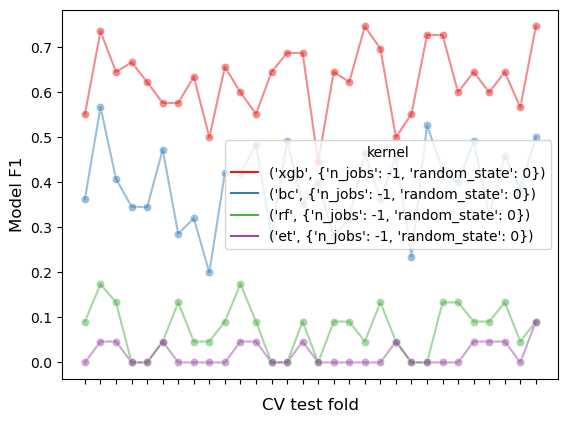

Correlation of models:
 kernel                                      ('xgb', {'n_jobs': -1, 'random_state': 0})  \
kernel                                                                                   
('xgb', {'n_jobs': -1, 'random_state': 0})                                    1.000000   
('bc', {'n_jobs': -1, 'random_state': 0})                                     0.426188   
('rf', {'n_jobs': -1, 'random_state': 0})                                     0.114492   
('et', {'n_jobs': -1, 'random_state': 0})                                     0.047567   

kernel                                      ('bc', {'n_jobs': -1, 'random_state': 0})  \
kernel                                                                                  
('xgb', {'n_jobs': -1, 'random_state': 0})                                   0.426188   
('bc', {'n_jobs': -1, 'random_state': 0})                                    1.000000   
('rf', {'n_jobs': -1, 'random_state': 0})                                    0.

In [68]:
# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_score")

# plot 30 examples of dependency between cv fold and F1 scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model F1", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

# print correlation of F1 scores across folds
print(f"Correlation of models:\n {model_scores.transpose().corr()}")

In [69]:
results_df.to_csv('../data/EEG_task3/ERSP_data2_F1_results.csv')
#results_df = pd.read_csv('../data/EEG_task3/ERSP_data2_F1_results.csv')
#results_df.head()

### SVC ROC AUC
These part of code originates from sklearn website, not original but helpful

In [8]:
param_grid = [
    {"kernel": ["linear"]},
    {"kernel": ["poly"], "degree": [2, 3]},
    {"kernel": ["rbf"]},
]

svc = SVC(random_state=0)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring="roc_auc", cv=cv)
%time search.fit(feature_df, target_df)

CPU times: user 2h 36min 45s, sys: 1min 13s, total: 2h 37min 59s
Wall time: 2h 37min 58s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=0),
             estimator=SVC(random_state=0),
             param_grid=[{'kernel': ['linear']},
                         {'degree': [2, 3], 'kernel': ['poly']},
                         {'kernel': ['rbf']}],
             scoring='roc_auc')

In [10]:
results_df = pd.DataFrame(search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

params  rank_test_score  mean_test_score  \
kernel                                                                      
2_poly  {'degree': 2, 'kernel': 'poly'}                1         0.532599   
3_poly  {'degree': 3, 'kernel': 'poly'}                2         0.531254   
linear             {'kernel': 'linear'}                3         0.529868   
rbf                   {'kernel': 'rbf'}                4         0.524921   

        std_test_score  
kernel                  
2_poly        0.047558  
3_poly        0.050666  
linear        0.046457  
rbf           0.047739

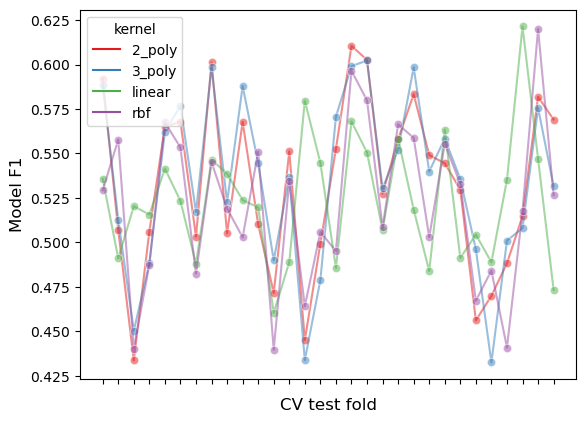

Correlation of models:
 kernel    2_poly    3_poly    linear       rbf
kernel                                        
2_poly  1.000000  0.935550  0.335536  0.701441
3_poly  0.935550  1.000000  0.285934  0.613009
linear  0.335536  0.285934  1.000000  0.383213
rbf     0.701441  0.613009  0.383213  1.000000


In [11]:
# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_score")

# plot 30 examples of dependency between cv fold and F1 scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model F1", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

# print correlation of F1 scores across folds
print(f"Correlation of models:\n {model_scores.transpose().corr()}")

## Check Precision-Recall Tradeoff

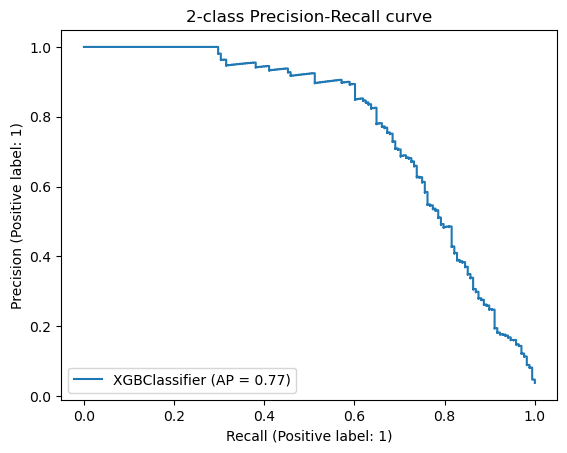

In [17]:
# test the tuned model with the precision recall trade-off plot
x_train, x_test, y_train, y_test = train_test_split(feature_df, target_df,
                                                    test_size=0.4, random_state=0,
                                                    stratify=target_df)
# generate random state
random_state = np.random.RandomState(0)

classifier = make_pipeline(col, xgb.XGBClassifier(random_state=159160009, 
                                                  n_jobs=-1, 
                                                  booster='gbtree',
                                                  n_estimators=50,
                                                  grow_policy='lossguide',
                                                  max_depth=12,
                                                  reg_alpha=0.4,
                                                  subsample=1,
                                                 ))
classifier.fit(x_train, y_train)

from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    classifier, x_test, y_test, name="XGBClassifier"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

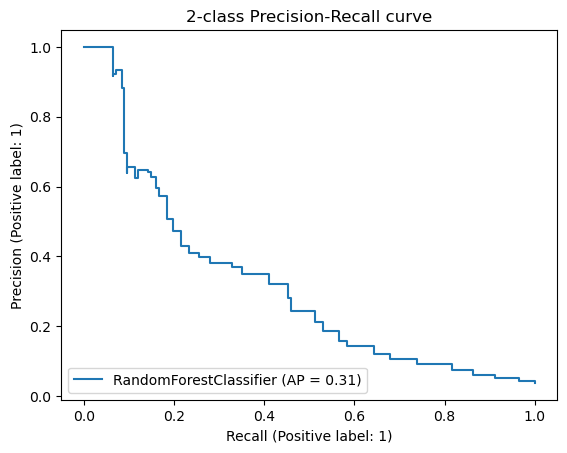

In [20]:
# test how bad the random forest is
x_train, x_test, y_train, y_test = train_test_split(feature_df, target_df,
                                                    test_size=0.4, random_state=0,
                                                    stratify=target_df)
# generate random state
random_state = np.random.RandomState(0)

classifier = make_pipeline(col, RandomForestClassifier(random_state=random_state, n_jobs=-1))
classifier.fit(x_train, y_train)

from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    classifier, x_test, y_test, name="RandomForestClassifier")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [19]:
# code copied from sklearn website
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

# Use label_binarize to be multi-label like settings
Y = label_binarize(target_df, classes=[0, 1])
n_classes = Y.shape[1]
# Split into training and test
x_train, x_test, y_train, y_test = train_test_split(feature_df, target_df, 
                                                    test_size=0.4, random_state=159160009,
                                                    stratify=target_df)
y_score = classifier.predict(x_test)
# For each class
precision = dict()
recall = dict()
average_precision = dict()
# TODO try pos label
precision[0], recall[0], _ = precision_recall_curve(y_test, y_score, pos_label=0)
average_precision[0] = average_precision_score(y_test, y_score, pos_label=0)

precision[1], recall[1], _ = precision_recall_curve(y_test, y_score, pos_label=1)
average_precision[1] = average_precision_score(y_test, y_score, pos_label=1)

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")

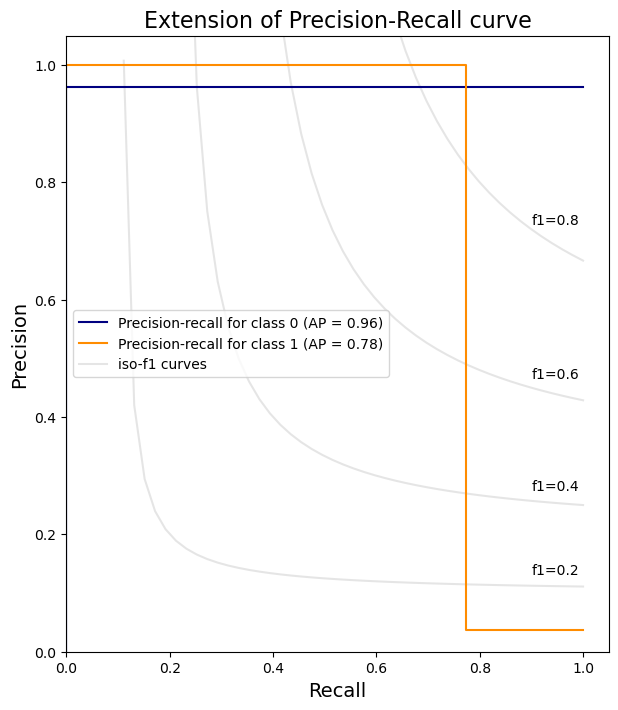

In [20]:
# precision-recall for each class
# copied from sklearn website
# also works with multiple class classification
import matplotlib.pyplot as plt
from itertools import cycle

# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

'''display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")'''

display = PrecisionRecallDisplay(
        recall=recall[0],
        precision=precision[0],
        average_precision=average_precision[0],
)
display.plot(ax=ax, name=f"Precision-recall for class {0}", color="navy")

display = PrecisionRecallDisplay(
        recall=recall[1],
        precision=precision[1],
        average_precision=average_precision[1],
)
display.plot(ax=ax, name=f"Precision-recall for class {1}", color="darkorange")

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.05])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve", fontsize=16)
plt.ylabel("Precision", fontsize=14)
plt.xlabel("Recall", fontsize=14)

plt.show()


In [35]:
classifier.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  Index(['c2_mean', 'c2_std', 'c2_min', 'c2_25%', 'c2_50%', 'c2_75%', 'c2_max',
       'c2_k', 'c3_mean', 'c3_std',
       ...
       'c28_max', 'c28_k', 'c29_mean', 'c29_std', 'c29_min', 'c29_25%',
       'c29_50%', 'c29_75%', 'c29_max', 'c29_k'],
      dtype='object', length=224))])),
                ('xgbc...
                               grow_policy='lossguide', importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=12, max_leaves=None,
                               min_child_weight=None, missing=na

## Parameter Tuning

In [14]:
pipe = Pipeline(steps=[
    ('col', ColumnTransformer([('num', RobustScaler(), feature_df.columns[1:-1]),], remainder='passthrough')),
    ('xgb', xgb.XGBClassifier())])
pipe

Pipeline(steps=[('col',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  Index(['c2_mean', 'c2_std', 'c2_min', 'c2_25%', 'c2_50%', 'c2_75%', 'c2_max',
       'c2_k', 'c3_mean', 'c3_std',
       ...
       'c28_max', 'c28_k', 'c29_mean', 'c29_std', 'c29_min', 'c29_25%',
       'c29_50%', 'c29_75%', 'c29_max', 'c29_k'],
      dtype='object', length=224))])),
                ('xgb',
                 XGBClassifier...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [73]:
param_grid = [
    {
        "xgb__grow_policy": ['lossguide', 'depthwise'],
        "xgb__booster": ['gbtree'],
        'xgb__max_depth': [12, 48, None],
        'xgb__colsample_bytree': [1],
        'xgb__subsample': [1],
        'xgb__n_jobs': [-1],
        'xgb__reg_alpha': [0.4],
        #'xgb__importance_type': ['gain', 'weight', 'cover', 'total_gain', 'total_cover'],
        'xgb__n_estimators': [50, 100],
        #'xgb__verbosity': [1],
        'xgb__random_state': [0],
        'xgb__scoring': [average_precision_score],
        'xgb__tree_method': ['exact', 'approx', 'hist'],
    },
]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0)

search = GridSearchCV(pipe, param_grid, scoring="average_precision", cv=cv)
%time search.fit(feature_df, target_df)

CPU times: user 23h 43min 53s, sys: 1h 49min 24s, total: 1d 1h 33min 17s
Wall time: 21min 26s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=10, random_state=0),
             estimator=Pipeline(steps=[('col',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         RobustScaler(),
                                                                         Index(['c2_mean', 'c2_std', 'c2_min', 'c2_25%', 'c2_50%', 'c2_75%', 'c2_max',
       'c2_k', 'c3_mean', 'c3_std',
       ...
       'c28_max', 'c28_k', 'c29_mean', 'c29_std', 'c29_min', 'c29_25%',...
                          'xgb__colsample_bytree': [1],
                          'xgb__grow_policy': ['lossguide', 'depthwise'],
                          'xgb__max_depth': [12, 48, None],
                          'xgb__n_estimators': [50, 100], 'xgb__n_jobs': [-1],
                          'xgb__random_state': [0], 'xgb__reg_alpha': [0.4],
                          'xgb__scoring': [<function average_precision_score at 0x2b3994472b90>],
                          'xgb__subsample': [1],
                          'xgb__tree_method': ['exact', 'approx', 'hist']}],
             scoring='average_precision')

In [74]:
results_df = pd.DataFrame(search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

params  \
kernel                                                                                                  
gbtree_1_lossguide_12_50_-1_0_0.4_<function ave...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_depthwise_12_50_-1_0_0.4_<function ave...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_depthwise_12_100_-1_0_0.4_<function av...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_lossguide_12_100_-1_0_0.4_<function av...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_lossguide_None_100_-1_0_0.4_<function ...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_depthwise_None_100_-1_0_0.4_<function ...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_lossguide_48_100_-1_0_0.4_<function av...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_depthwise_48_100_-1_0_0.4_<function av...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_lossguide_48_50_-1_0_0.4_<function ave...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_depthwise_48_50_-1_0_0.4_<function ave...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_depthwise_None_50_-1_0_0.4_<function a...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_lossguide_None_50_-1_0_0.4_<function a...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_lossguide_None_100_-1_0_0.4_<function ...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_depthwise_None_100_-1_0_0.4_<function ...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_lossguide_12_100_-1_0_0.4_<function av...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_depthwise_12_100_-1_0_0.4_<function av...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_lossguide_48_100_-1_0_0.4_<function av...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_depthwise_48_100_-1_0_0.4_<function av...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_lossguide_48_50_-1_0_0.4_<function ave...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_depthwise_48_50_-1_0_0.4_<function ave...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_depthwise_12_50_-1_0_0.4_<function ave...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_lossguide_12_50_-1_0_0.4_<function ave...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_depthwise_None_50_-1_0_0.4_<function a...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_lossguide_None_50_-1_0_0.4_<function a...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_depthwise_12_100_-1_0_0.4_<function av...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_lossguide_12_100_-1_0_0.4_<function av...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_lossguide_12_50_-1_0_0.4_<function ave...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_depthwise_12_50_-1_0_0.4_<function ave...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_lossguide_None_100_-1_0_0.4_<function ...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_depthwise_None_100_-1_0_0.4_<function ...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_lossguide_48_50_-1_0_0.4_<function ave...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_depthwise_48_50_-1_0_0.4_<function ave...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_lossguide_None_50_-1_0_0.4_<function a...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_depthwise_None_50_-1_0_0.4_<function a...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_depthwise_48_100_-1_0_0.4_<function av...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   
gbtree_1_lossguide_48_100_-1_0_0.4_<function av...  {'xgb__booster': 'gbtree', 'xgb__colsample_byt...   

                                                    rank_test_score  \
kernel                           

In [75]:
results_df.to_csv('../data/EEG_task3/ERSP_data2_finetune_avgPre_results.csv')

In [76]:
results_df['params'][0]

{'xgb__booster': 'gbtree',
 'xgb__colsample_bytree': 1,
 'xgb__grow_policy': 'lossguide',
 'xgb__max_depth': 12,
 'xgb__n_estimators': 50,
 'xgb__n_jobs': -1,
 'xgb__random_state': 0,
 'xgb__reg_alpha': 0.4,
 'xgb__scoring': <function sklearn.metrics._ranking.average_precision_score(y_true, y_score, *, average='macro', pos_label=1, sample_weight=None)>,
 'xgb__subsample': 1,
 'xgb__tree_method': 'exact'}

CPU times: user 1min 50s, sys: 6.93 s, total: 1min 57s
Wall time: 1.77 s


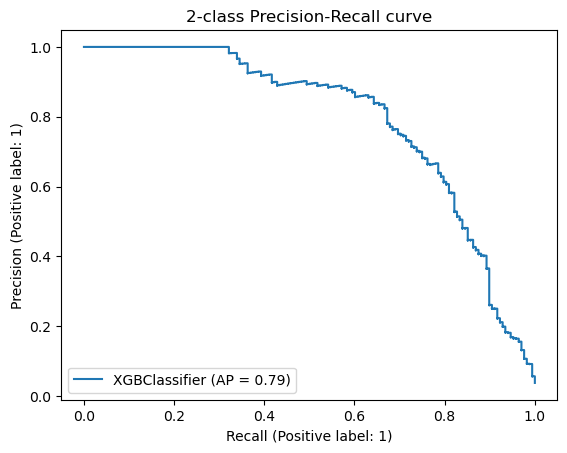

In [21]:
x_train, x_test, y_train, y_test = train_test_split(feature_df, target_df, 
                                                    test_size=0.4, random_state=0,
                                                    stratify=target_df)
# generate random state
random_state = np.random.RandomState(0)

classifier = make_pipeline(col, xgb.XGBClassifier(random_state=0, 
                                                  n_jobs=-1, 
                                                  booster='gbtree',
                                                  n_estimators=50,
                                                  grow_policy='lossguide',
                                                  max_depth=50,
                                                  reg_alpha=0.4,
                                                  subsample=1,
                                                  colsample_bytree=1,
                                                  scoring=average_precision_score,
                                                  tree_method='exact'
                                                 ))
#'xgb__tree_method': ['exact', 'approx', 'hist'],
%time classifier.fit(x_train, y_train)

from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(classifier, x_test, y_test, name="XGBClassifier")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [23]:
y_pred = classifier.predict(x_test)
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, y_pred)}\n"
)

Classification report for classifier XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=50, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=0, ...):
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4296
           1       1.00      0.26      0.41       168

    accuracy                           0.97   

In [22]:
# average Precision
clf = xgb.XGBClassifier(random_state=0, n_jobs=-1, 
                                        booster='gbtree',
                                        n_estimators=50,
                                        grow_policy='lossguide',
                                        max_depth=50,
                                        reg_alpha=0.4,
                                        subsample=1,
                                        colsample_bytree=1,
                                        scoring=average_precision_score,
                                        tree_method='exact')
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)
pipe = make_pipeline(col, clf) # can add ColumnTransformer
%time scores = cross_val_score(pipe, feature_df, target_df, cv=rskf, scoring='average_precision')
print("Avg score: {:.5} with std {:.5}".format(scores.mean(), scores.std()))


KeyboardInterrupt



NameError: name 'scores' is not defined

In [81]:
# average Precision
clf = xgb.XGBClassifier(random_state=0, n_jobs=-1, 
                                        booster='gbtree',
                                        n_estimators=50,
                                        grow_policy='lossguide',
                                        max_depth=12,
                                        reg_alpha=0.4,
                                        subsample=1,
                                        colsample_bytree=1,
                                        scoring=average_precision_score,
                                        tree_method='exact')
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)
pipe = make_pipeline(col, clf) # can add ColumnTransformer
%time scores = cross_val_score(pipe, feature_df, target_df, cv=rskf, scoring='average_precision')
print("Avg score: {:.5} with std {:.5}".format(scores.mean(), scores.std()))

CPU times: user 2h 28min 22s, sys: 5min 55s, total: 2h 34min 18s
Wall time: 1min 57s
Avg score: 0.93001 with std 0.029111
